In [1]:
import warnings
warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
import _pickle as cpickle
import seaborn as sns
import pickle
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score,roc_curve
from sklearn.metrics import f1_score, classification_report

In [2]:
# Loading data
!pip3 install pickle5
import pickle5 as pickle
with open("/content/drive/MyDrive/X.pkl", "rb") as fh:
  X = pickle.load(fh)
with open("/content/drive/MyDrive/y.pkl", "rb") as fh:
  y = pickle.load(fh)

In [3]:
def plot_confusion_matrix(test_y, predict_y):
    """
    Utility function to print confusion matrix
    """
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [4]:
# Sample 60% of the data with replacement
def sampling_with_replacement(inp_data, target_data):
  """
  this function samples 60% of the rows with replacement and returns the
  sampled input and target data
  """
  selecting_rows = np.random.choice(list(range(inp_data.shape[0])),
                                    size=int(0.6 * len(inp_data)),replace=True)
  final_sample_data = inp_data.iloc[selecting_rows]
  final_target_data = target_data.iloc[selecting_rows]

  return final_sample_data , final_target_data

In [5]:
# generate 'k' samples using sample with replacement
from tqdm import tqdm
def generate_k_samples(inp_data,target_data,k):
  """
  this function generates k samples using the above function which is 
  later used to train each of the k models
  """
  list_input_data =[]
  list_target_data =[]

  for i in tqdm(range(k)):
    a,b = sampling_with_replacement(inp_data,target_data)
    list_input_data.append(a)
    list_target_data.append(b)

  return list_input_data, list_target_data  

In [6]:
# Build 'k' models 
from tqdm import tqdm
import itertools
import pdb  

def build_model(list_input_data,list_output_data,k,base_models):
  """
  this function is to build/create k models in a cycle and trains kth model with
  kth sample. We train different models with different samples.
  """ 
  temp = 0
  list_of_all_models = []
  for model in itertools.cycle(base_models):
    if(temp >= k):
      break
    else:
      model.fit(list_input_data[temp],list_output_data[temp]) 
      list_of_all_models.append(model)
      temp = temp + 1

  return list_of_all_models  

In [7]:
# To get k predictions for each of the k models
import pdb
def get_k_model_predictions(X_D2,models):
  """ 
  this function uses k models to get k predictions for the passed data.
  Using these k predictions a new dataset is created.
  """
  k_predictions = []
  for model in models:
    #pdb.set_trace()
    y_pred = (model.predict_proba(X_D2)[:, 1] >= 0.21).astype('int')
    k_predictions.append(y_pred)
  
  df_predictions = create_df_for_predictions(len(models),k_predictions)

  return df_predictions

In [8]:
# create a new dataset from predictions
def create_df_for_predictions(n, predictions):
  """
  this function creates a new dataset from the predictions that we
  get from each of the n models. 
  """
  df = pd.DataFrame()
  for i in range(n):
    df['prediction_'+str(i)] = predictions[i] 

  return df 

In [9]:
def Custom_Stacking_Classfier(X,y,k,base_models):
  """
  This is the main function that implements the custom stacking classifier
  """
  print("splitting data into train and test(80-20)...")
  # Split your whole data into train and test(80-20)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=10,stratify=y)

  print("splitting train set into D1 and D2(50-50)...")
  # Now, in the 80% train set, split the train set into D1 and D2.(50-50).
  X_D1, X_D2 , y_D1, y_D2 = train_test_split(X_train, y_train, test_size=0.5,
                                             random_state=10,stratify=y_train)

  print("Generating samples with replacement...")
  # Generate k such samples using sampling with replacement
  list_input_data, list_target_data = generate_k_samples(X_D1, y_D1,k)
  

  print("Building models...")
  # create 'k' models and train each of these models with each of these k samples.
  models = build_model(list_input_data, list_target_data,k,base_models)

  print("Predicting...")
  # pass the D2 set to each of these k models; we will get k predictions 
  # for D2 from each of these models.
  # using these k predictions, create a new dataset
  predictions_meta_data = get_k_model_predictions(X_D2,models)

  print("Building meta model...")
  # train a metamodel with these k predictions
  meta_model = CatBoostClassifier(depth=12,iterations=1000,task_type='GPU')
  meta_model.fit(predictions_meta_data,y_D2)

  print("Evaluating Model...")
  # Now, for model evaluation, we use the 20% data that we have kept 
  predictions_meta_data_test = get_k_model_predictions(X_test,models)
  y_pred_test = (meta_model.predict_proba(predictions_meta_data_test)[:, 1] >= 0.21).astype('int') 
  print("Complete")

  return f1_score(y_test,y_pred_test),y_test,y_pred_test


**<h3>Hyper-Paramter Tuning(number of base models with different base models)**



*   **Number of base models - [5,10,15,20,25]**
*   **base models - LGBMClassifier, DecisionTreeClassifier**



In [ ]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20,25]
f1_scores = []
base_models = [lgb.LGBMClassifier(objective='binary'),DecisionTreeClassifier()]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Building models...
Predicting...
Building meta model...
Learning rate set to 0.331377
0:	learn: 0.4180754	total: 1.11s	remaining: 18m 31s
1:	learn: 0.3251392	total: 1.94s	remaining: 16m 5s
2:	learn: 0.2920549	total: 2.75s	remaining: 15m 12s
3:	learn: 0.2794528	total: 3.55s	remaining: 14m 44s
4:	learn: 0.2744667	total: 4.28s	remaining: 14m 12s
5:	learn: 0.2723202	total: 5.07s	remaining: 13m 59s
6:	learn: 0.2714060	total: 5.85s	remaining: 13m 50s
7:	learn: 0.2710102	total: 6.62s	remaining: 13m 40s
8:	learn: 0.2708370	total: 7.4s	remaining: 13m 34s
9:	learn: 0.2707607	total: 8.18s	remaining: 13m 29s
10:	learn: 0.2707276	total: 8.93s	remaining: 13m 22s
11:	learn: 0.2707122	total: 9.66s	remaining: 13m 15s
12:	learn: 0.2707057	total: 10.4s	remaining: 13m 7s
13:	learn: 0.2707024	total: 11.1s	remaining: 13m
14:	learn: 0.2707010	total: 11.8s	remaining: 12m 55s
15:	learn: 0.2707010	total: 12.5s	remaining: 12m 49s
16:	learn: 0.2707010	total: 13.2s	remaining: 12m 43s
17:	learn: 0.2707010	total: 13

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Building models...
Predicting...
Building meta model...
Learning rate set to 0.331377
0:	learn: 0.4183795	total: 859ms	remaining: 14m 18s
1:	learn: 0.3254561	total: 1.63s	remaining: 13m 33s
2:	learn: 0.2923489	total: 2.41s	remaining: 13m 20s
3:	learn: 0.2797319	total: 3.17s	remaining: 13m 10s
4:	learn: 0.2746664	total: 3.93s	remaining: 13m 2s
5:	learn: 0.2725583	total: 4.66s	remaining: 12m 52s
6:	learn: 0.2716596	total: 5.43s	remaining: 12m 50s
7:	learn: 0.2712704	total: 6.16s	remaining: 12m 43s
8:	learn: 0.2711350	total: 6.89s	remaining: 12m 38s
9:	learn: 0.2710403	total: 7.61s	remaining: 12m 33s
10:	learn: 0.2709989	total: 8.31s	remaining: 12m 27s
11:	learn: 0.2709800	total: 9.07s	remaining: 12m 26s
12:	learn: 0.2709716	total: 9.79s	remaining: 12m 23s
13:	learn: 0.2709679	total: 10.5s	remaining: 12m 18s
14:	learn: 0.2709662	total: 11.2s	remaining: 12m 14s
15:	learn: 0.2709662	total: 11.8s	remaining: 12m 7s
16:	learn: 0.2709656	total: 12.5s	remaining: 12m 3s
17:	learn: 0.2709653	total

In [ ]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  20
Best F1-Score:  0.4354849458892768


*   **Number of base models - [5,10,15,20]**
*   **base models - LGBMClassifier, DecisionTreeClassifier, CatBoostClassifier**

In [ ]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20]
f1_scores = []
base_models = [lgb.LGBMClassifier(objective='binary'),DecisionTreeClassifier(),CatBoostClassifier(task_type='GPU')]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663124	total: 44.7ms	remaining: 44.7s
1:	learn: 0.6413724	total: 86.5ms	remaining: 43.2s
2:	learn: 0.6187046	total: 126ms	remaining: 41.7s
3:	learn: 0.5975099	total: 167ms	remaining: 41.5s
4:	learn: 0.5774547	total: 208ms	remaining: 41.4s
5:	learn: 0.5578580	total: 251ms	remaining: 41.6s
6:	learn: 0.5399937	total: 279ms	remaining: 39.6s
7:	learn: 0.5228827	total: 307ms	remaining: 38.1s
8:	learn: 0.5067038	total: 336ms	remaining: 37s
9:	learn: 0.4921040	total: 364ms	remaining: 36s
10:	learn: 0.4785448	total: 392ms	remaining: 35.3s
11:	learn: 0.4659390	total: 419ms	remaining: 34.5s
12:	learn: 0.4541272	total: 444ms	remaining: 33.7s
13:	learn: 0.4423982	total: 473ms	remaining: 33.3s
14:	learn: 0.4320811	total: 498ms	remaining: 32.7s
15:	learn: 0.4226891	total: 523ms	remaining: 32.2s
16:	learn: 0.4133887	total: 550ms	remaining: 31.8s
17:	learn: 0.4042873	total: 575ms	remaining: 31.4s
18:	learn: 0.3961278	total: 602ms	remaining: 

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6662042	total: 51.3ms	remaining: 51.3s
1:	learn: 0.6412462	total: 93.6ms	remaining: 46.7s
2:	learn: 0.6188111	total: 130ms	remaining: 43.3s
3:	learn: 0.5975982	total: 168ms	remaining: 41.8s
4:	learn: 0.5775861	total: 207ms	remaining: 41.2s
5:	learn: 0.5578845	total: 248ms	remaining: 41.1s
6:	learn: 0.5400242	total: 291ms	remaining: 41.3s
7:	learn: 0.5229507	total: 319ms	remaining: 39.5s
8:	learn: 0.5067675	total: 348ms	remaining: 38.4s
9:	learn: 0.4919539	total: 377ms	remaining: 37.3s
10:	learn: 0.4783761	total: 404ms	remaining: 36.3s
11:	learn: 0.4651257	total: 431ms	remaining: 35.5s
12:	learn: 0.4534095	total: 456ms	remaining: 34.6s
13:	learn: 0.4423737	total: 482ms	remaining: 33.9s
14:	learn: 0.4322745	total: 512ms	remaining: 33.6s
15:	learn: 0.4225760	total: 538ms	remaining: 33.1s
16:	learn: 0.4131795	total: 564ms	remaining: 32.6s
17:	learn: 0.4041838	total: 590ms	remaining: 32.2s
18:	learn: 0.3957233	total: 617ms	remaini

  0%|          | 0/15 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


Streaming output truncated to the last 5000 lines.
10:	learn: 0.4779931	total: 395ms	remaining: 35.5s
11:	learn: 0.4648891	total: 420ms	remaining: 34.5s
12:	learn: 0.4530448	total: 445ms	remaining: 33.8s
13:	learn: 0.4415752	total: 471ms	remaining: 33.2s
14:	learn: 0.4312195	total: 506ms	remaining: 33.3s
15:	learn: 0.4216673	total: 531ms	remaining: 32.7s
16:	learn: 0.4123161	total: 557ms	remaining: 32.2s
17:	learn: 0.4038864	total: 582ms	remaining: 31.7s
18:	learn: 0.3954042	total: 608ms	remaining: 31.4s
19:	learn: 0.3873420	total: 634ms	remaining: 31.1s
20:	learn: 0.3801491	total: 659ms	remaining: 30.7s
21:	learn: 0.3728772	total: 686ms	remaining: 30.5s
22:	learn: 0.3659814	total: 722ms	remaining: 30.7s
23:	learn: 0.3599956	total: 746ms	remaining: 30.3s
24:	learn: 0.3544277	total: 771ms	remaining: 30.1s
25:	learn: 0.3495088	total: 795ms	remaining: 29.8s
26:	learn: 0.3440475	total: 821ms	remaining: 29.6s
27:	learn: 0.3391373	total: 847ms	remaining: 29.4s
28:	learn: 0.3347497	total: 871

  0%|          | 0/20 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


Streaming output truncated to the last 5000 lines.
8:	learn: 0.5062579	total: 338ms	remaining: 37.2s
9:	learn: 0.4915324	total: 371ms	remaining: 36.7s
10:	learn: 0.4779398	total: 399ms	remaining: 35.9s
11:	learn: 0.4645583	total: 426ms	remaining: 35.1s
12:	learn: 0.4528980	total: 460ms	remaining: 34.9s
13:	learn: 0.4415372	total: 503ms	remaining: 35.4s
14:	learn: 0.4317107	total: 527ms	remaining: 34.6s
15:	learn: 0.4218392	total: 554ms	remaining: 34.1s
16:	learn: 0.4132157	total: 578ms	remaining: 33.4s
17:	learn: 0.4042577	total: 604ms	remaining: 32.9s
18:	learn: 0.3956259	total: 630ms	remaining: 32.5s
19:	learn: 0.3880249	total: 656ms	remaining: 32.1s
20:	learn: 0.3809711	total: 681ms	remaining: 31.8s
21:	learn: 0.3737824	total: 724ms	remaining: 32.2s
22:	learn: 0.3669261	total: 750ms	remaining: 31.9s
23:	learn: 0.3610978	total: 774ms	remaining: 31.5s
24:	learn: 0.3553500	total: 802ms	remaining: 31.3s
25:	learn: 0.3506567	total: 827ms	remaining: 31s
26:	learn: 0.3455527	total: 852ms	r

In [ ]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  5
Best F1-Score:  0.43614467933466794


* **Number of base models - [5,10,15,20]**
* **base models - LGBMClassifier, DecisionTreeClassifier, CatBoostClassifier, XGBClassifier**

In [ ]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20]
f1_scores = []
base_models = [lgb.LGBMClassifier(objective='binary'),DecisionTreeClassifier(),CatBoostClassifier(task_type='GPU'),XGBClassifier(tree_method='gpu_hist')]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663303	total: 45.7ms	remaining: 45.7s
1:	learn: 0.6412491	total: 87.8ms	remaining: 43.8s
2:	learn: 0.6187663	total: 127ms	remaining: 42.2s
3:	learn: 0.5975117	total: 169ms	remaining: 42s
4:	learn: 0.5774597	total: 211ms	remaining: 41.9s
5:	learn: 0.5576767	total: 244ms	remaining: 40.4s
6:	learn: 0.5394164	total: 280ms	remaining: 39.7s
7:	learn: 0.5229017	total: 308ms	remaining: 38.2s
8:	learn: 0.5074749	total: 336ms	remaining: 37s
9:	learn: 0.4928082	total: 367ms	remaining: 36.3s
10:	learn: 0.4794429	total: 395ms	remaining: 35.5s
11:	learn: 0.4664601	total: 422ms	remaining: 34.8s
12:	learn: 0.4541610	total: 449ms	remaining: 34.1s
13:	learn: 0.4429684	total: 475ms	remaining: 33.4s
14:	learn: 0.4325782	total: 503ms	remaining: 33s
15:	learn: 0.4230089	total: 529ms	remaining: 32.6s
16:	learn: 0.4141561	total: 554ms	remaining: 32s
17:	learn: 0.4048810	total: 580ms	remaining: 31.6s
18:	learn: 0.3962483	total: 631ms	remaining: 32.6

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663786	total: 51.8ms	remaining: 51.7s
1:	learn: 0.6413446	total: 93.7ms	remaining: 46.8s
2:	learn: 0.6188786	total: 137ms	remaining: 45.5s
3:	learn: 0.5968915	total: 179ms	remaining: 44.6s
4:	learn: 0.5769569	total: 220ms	remaining: 43.7s
5:	learn: 0.5573375	total: 267ms	remaining: 44.2s
6:	learn: 0.5392476	total: 296ms	remaining: 42s
7:	learn: 0.5222412	total: 324ms	remaining: 40.2s
8:	learn: 0.5067322	total: 355ms	remaining: 39s
9:	learn: 0.4919670	total: 384ms	remaining: 38s
10:	learn: 0.4784365	total: 413ms	remaining: 37.1s
11:	learn: 0.4658521	total: 439ms	remaining: 36.1s
12:	learn: 0.4539967	total: 465ms	remaining: 35.3s
13:	learn: 0.4426813	total: 492ms	remaining: 34.7s
14:	learn: 0.4325857	total: 517ms	remaining: 33.9s
15:	learn: 0.4221377	total: 545ms	remaining: 33.5s
16:	learn: 0.4128202	total: 572ms	remaining: 33.1s
17:	learn: 0.4041182	total: 599ms	remaining: 32.7s
18:	learn: 0.3955491	total: 627ms	remaining: 32

In [ ]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  15
Best F1-Score:  0.4361641228856645


* **Number of base models - [5,10,15,20]**
* **base models - CatBoostClassifier, XGBClassifier**

In [ ]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20]
f1_scores = []
base_models = [CatBoostClassifier(task_type='GPU'),XGBClassifier(tree_method='gpu_hist')]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6662311	total: 46.9ms	remaining: 46.9s
1:	learn: 0.6411550	total: 88.9ms	remaining: 44.3s
2:	learn: 0.6186766	total: 128ms	remaining: 42.6s
3:	learn: 0.5975351	total: 165ms	remaining: 41.2s
4:	learn: 0.5774812	total: 196ms	remaining: 39.1s
5:	learn: 0.5578023	total: 228ms	remaining: 37.8s
6:	learn: 0.5395986	total: 262ms	remaining: 37.2s
7:	learn: 0.5226274	total: 293ms	remaining: 36.3s
8:	learn: 0.5064642	total: 324ms	remaining: 35.6s
9:	learn: 0.4917201	total: 354ms	remaining: 35.1s
10:	learn: 0.4785269	total: 381ms	remaining: 34.2s
11:	learn: 0.4651276	total: 408ms	remaining: 33.6s
12:	learn: 0.4534012	total: 433ms	remaining: 32.9s
13:	learn: 0.4422673	total: 476ms	remaining: 33.5s
14:	learn: 0.4321434	total: 500ms	remaining: 32.8s
15:	learn: 0.4216019	total: 528ms	remaining: 32.5s
16:	learn: 0.4123922	total: 555ms	remaining: 32.1s
17:	learn: 0.4034286	total: 582ms	remaining: 31.8s
18:	learn: 0.3949878	total: 613ms	remaini

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Streaming output truncated to the last 5000 lines.
8:	learn: 0.5062986	total: 358ms	remaining: 39.4s
9:	learn: 0.4915741	total: 389ms	remaining: 38.6s
10:	learn: 0.4779912	total: 417ms	remaining: 37.5s
11:	learn: 0.4645147	total: 445ms	remaining: 36.6s
12:	learn: 0.4525549	total: 482ms	remaining: 36.6s
13:	learn: 0.4408564	total: 508ms	remaining: 35.8s
14:	learn: 0.4307745	total: 533ms	remaining: 35s
15:	learn: 0.4204353	total: 561ms	remaining: 34.5s
16:	learn: 0.4112941	total: 588ms	remaining: 34s
17:	learn: 0.4024717	total: 615ms	remaining: 33.6s
18:	learn: 0.3940218	total: 643ms	remaining: 33.2s
19:	learn: 0.3861173	total: 669ms	remaining: 32.8s
20:	learn: 0.3787599	total: 707ms	remaining: 33s
21:	learn: 0.3721092	total: 734ms	remaining: 32.6s
22:	learn: 0.3657248	total: 761ms	remaining: 32.3s
23:	learn: 0.3599823	total: 787ms	remaining: 32s
24:	learn: 0.3545839	total: 813ms	remaining: 31.7s
25:	learn: 0.3495496	total: 841ms	remaining: 31.5s
26:	learn: 0.3441251	total: 868ms	remaini

In [ ]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  15
Best F1-Score:  0.43599380597769843


* **Number of base models - [5,10,15,20]**
* **base models - CatBoostClassifier, LGBMClassifier**

In [ ]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20]
f1_scores = []
base_models = [lgb.LGBMClassifier(objective='binary'),CatBoostClassifier(task_type='GPU')]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663325	total: 44.5ms	remaining: 44.5s
1:	learn: 0.6414132	total: 86.4ms	remaining: 43.1s
2:	learn: 0.6187822	total: 135ms	remaining: 44.7s
3:	learn: 0.5975586	total: 176ms	remaining: 43.9s
4:	learn: 0.5775171	total: 208ms	remaining: 41.4s
5:	learn: 0.5578693	total: 241ms	remaining: 39.9s
6:	learn: 0.5400095	total: 277ms	remaining: 39.2s
7:	learn: 0.5230353	total: 307ms	remaining: 38.1s
8:	learn: 0.5070589	total: 338ms	remaining: 37.2s
9:	learn: 0.4923288	total: 369ms	remaining: 36.6s
10:	learn: 0.4787776	total: 398ms	remaining: 35.8s
11:	learn: 0.4663111	total: 422ms	remaining: 34.8s
12:	learn: 0.4544767	total: 447ms	remaining: 33.9s
13:	learn: 0.4428573	total: 472ms	remaining: 33.3s
14:	learn: 0.4325190	total: 501ms	remaining: 32.9s
15:	learn: 0.4226345	total: 528ms	remaining: 32.5s
16:	learn: 0.4133266	total: 555ms	remaining: 32.1s
17:	learn: 0.4045736	total: 580ms	remaining: 31.7s
18:	learn: 0.3961029	total: 607ms	remaini

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:12<00:00,  1.26s/it]


Streaming output truncated to the last 5000 lines.
10:	learn: 0.4780111	total: 413ms	remaining: 37.1s
11:	learn: 0.4651171	total: 439ms	remaining: 36.2s
12:	learn: 0.4533576	total: 464ms	remaining: 35.3s
13:	learn: 0.4415602	total: 502ms	remaining: 35.3s
14:	learn: 0.4313241	total: 528ms	remaining: 34.6s
15:	learn: 0.4210235	total: 555ms	remaining: 34.1s
16:	learn: 0.4124195	total: 580ms	remaining: 33.5s
17:	learn: 0.4034467	total: 607ms	remaining: 33.1s
18:	learn: 0.3951297	total: 634ms	remaining: 32.7s
19:	learn: 0.3876422	total: 661ms	remaining: 32.4s
20:	learn: 0.3801660	total: 689ms	remaining: 32.1s
21:	learn: 0.3733699	total: 725ms	remaining: 32.2s
22:	learn: 0.3664979	total: 752ms	remaining: 31.9s
23:	learn: 0.3603039	total: 780ms	remaining: 31.7s
24:	learn: 0.3544860	total: 807ms	remaining: 31.5s
25:	learn: 0.3497002	total: 832ms	remaining: 31.2s
26:	learn: 0.3445858	total: 865ms	remaining: 31.2s
27:	learn: 0.3397582	total: 892ms	remaining: 31s
28:	learn: 0.3353115	total: 922ms

  0%|          | 0/15 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 15/15 [00:19<00:00,  1.33s/it]


Streaming output truncated to the last 5000 lines.
10:	learn: 0.4789682	total: 419ms	remaining: 37.6s
11:	learn: 0.4656519	total: 449ms	remaining: 36.9s
12:	learn: 0.4535626	total: 475ms	remaining: 36.1s
13:	learn: 0.4417209	total: 516ms	remaining: 36.4s
14:	learn: 0.4313932	total: 541ms	remaining: 35.5s
15:	learn: 0.4210534	total: 569ms	remaining: 35s
16:	learn: 0.4118333	total: 597ms	remaining: 34.5s
17:	learn: 0.4028938	total: 624ms	remaining: 34s
18:	learn: 0.3947915	total: 652ms	remaining: 33.6s
19:	learn: 0.3865830	total: 680ms	remaining: 33.3s
20:	learn: 0.3792144	total: 708ms	remaining: 33s
21:	learn: 0.3725108	total: 744ms	remaining: 33.1s
22:	learn: 0.3661161	total: 771ms	remaining: 32.7s
23:	learn: 0.3601730	total: 797ms	remaining: 32.4s
24:	learn: 0.3542586	total: 825ms	remaining: 32.2s
25:	learn: 0.3496093	total: 852ms	remaining: 31.9s
26:	learn: 0.3441910	total: 880ms	remaining: 31.7s
27:	learn: 0.3393851	total: 907ms	remaining: 31.5s
28:	learn: 0.3349704	total: 934ms	rem

  0%|          | 0/20 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


Streaming output truncated to the last 5000 lines.
8:	learn: 0.5065187	total: 365ms	remaining: 40.2s
9:	learn: 0.4916057	total: 395ms	remaining: 39.1s
10:	learn: 0.4780566	total: 424ms	remaining: 38.2s
11:	learn: 0.4651224	total: 451ms	remaining: 37.1s
12:	learn: 0.4534540	total: 491ms	remaining: 37.3s
13:	learn: 0.4422277	total: 522ms	remaining: 36.7s
14:	learn: 0.4321170	total: 546ms	remaining: 35.9s
15:	learn: 0.4225985	total: 574ms	remaining: 35.3s
16:	learn: 0.4133482	total: 601ms	remaining: 34.7s
17:	learn: 0.4041481	total: 628ms	remaining: 34.2s
18:	learn: 0.3955471	total: 655ms	remaining: 33.8s
19:	learn: 0.3876169	total: 683ms	remaining: 33.5s
20:	learn: 0.3802178	total: 727ms	remaining: 33.9s
21:	learn: 0.3735699	total: 752ms	remaining: 33.5s
22:	learn: 0.3670379	total: 779ms	remaining: 33.1s
23:	learn: 0.3612427	total: 804ms	remaining: 32.7s
24:	learn: 0.3554843	total: 831ms	remaining: 32.4s
25:	learn: 0.3503442	total: 856ms	remaining: 32.1s
26:	learn: 0.3449116	total: 883ms

In [ ]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  5
Best F1-Score:  0.43589013288038697


* **Number of base models - [5,10,15,20]**
* **base models - CatBoostClassifier, LGBMClassifier, XGBClassifier**

In [10]:
# hyper Parameter Tuning(number of base models)
no_of_base_models = [5,10,15,20]
f1_scores = []
base_models = [lgb.LGBMClassifier(objective='binary'),CatBoostClassifier(task_type='GPU'),XGBClassifier(tree_method='gpu_hist')]
y = y.astype('int')
for k in no_of_base_models:
  f1_score_val,_,_ = Custom_Stacking_Classfier(X,y,k,base_models)
  f1_scores.append(f1_score_val)

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663595	total: 46ms	remaining: 46s
1:	learn: 0.6413048	total: 88.1ms	remaining: 44s
2:	learn: 0.6188791	total: 127ms	remaining: 42.4s
3:	learn: 0.5968634	total: 171ms	remaining: 42.5s
4:	learn: 0.5768830	total: 213ms	remaining: 42.3s
5:	learn: 0.5573087	total: 259ms	remaining: 42.9s
6:	learn: 0.5391915	total: 288ms	remaining: 40.9s
7:	learn: 0.5226353	total: 315ms	remaining: 39s
8:	learn: 0.5071740	total: 341ms	remaining: 37.6s
9:	learn: 0.4922327	total: 371ms	remaining: 36.7s
10:	learn: 0.4789765	total: 397ms	remaining: 35.7s
11:	learn: 0.4663089	total: 424ms	remaining: 34.9s
12:	learn: 0.4545241	total: 450ms	remaining: 34.2s
13:	learn: 0.4430950	total: 481ms	remaining: 33.9s
14:	learn: 0.4328165	total: 506ms	remaining: 33.2s
15:	learn: 0.4232780	total: 532ms	remaining: 32.7s
16:	learn: 0.4144495	total: 556ms	remaining: 32.2s
17:	learn: 0.4057505	total: 584ms	remaining: 31.9s
18:	learn: 0.3970968	total: 611ms	remaining: 31.6

  0%|          | 0/10 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6661726	total: 51.8ms	remaining: 51.7s
1:	learn: 0.6410585	total: 93.8ms	remaining: 46.8s
2:	learn: 0.6182685	total: 141ms	remaining: 46.9s
3:	learn: 0.5971000	total: 188ms	remaining: 46.8s
4:	learn: 0.5770099	total: 224ms	remaining: 44.6s
5:	learn: 0.5573124	total: 260ms	remaining: 43.1s
6:	learn: 0.5390328	total: 290ms	remaining: 41.1s
7:	learn: 0.5220896	total: 318ms	remaining: 39.4s
8:	learn: 0.5061340	total: 348ms	remaining: 38.3s
9:	learn: 0.4914375	total: 376ms	remaining: 37.3s
10:	learn: 0.4778081	total: 405ms	remaining: 36.5s
11:	learn: 0.4650526	total: 431ms	remaining: 35.5s
12:	learn: 0.4529090	total: 457ms	remaining: 34.7s
13:	learn: 0.4418609	total: 490ms	remaining: 34.5s
14:	learn: 0.4315252	total: 514ms	remaining: 33.7s
15:	learn: 0.4210936	total: 541ms	remaining: 33.3s
16:	learn: 0.4117733	total: 567ms	remaining: 32.8s
17:	learn: 0.4029792	total: 592ms	remaining: 32.3s
18:	learn: 0.3949281	total: 618ms	remaini

In [13]:
# Get the maximum F1 score and the corresponding no of base models
print('Best Number of Base Models: ', no_of_base_models[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best Number of Base Models:  5
Best F1-Score:  0.4363639185176756


**<h4>Model Evaluation**

<h6>Choosing the best combination of base models and number of base models

In [14]:
# Best Combination of base models - CatBoostClassifier, LGBMClassifier, XGBClassifier
# Best number of base models      - 5

base_models = [lgb.LGBMClassifier(objective='binary'),CatBoostClassifier(task_type='GPU'),XGBClassifier(tree_method='gpu_hist')]
k = 5

y = y.astype('int')


print("splitting data into train and test(80-20)...")
# Split your whole data into train and test(80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                      random_state=10,stratify=y)

print("splitting train set into D1 and D2(50-50)...")
# Now, in the 80% train set, split the train set into D1 and D2.(50-50).
X_D1, X_D2 , y_D1, y_D2 = train_test_split(X_train, y_train, test_size=0.5,
                                             random_state=10,stratify=y_train)

print("Generating samples with replacement...")
# Generate k such samples using sampling with replacement
list_input_data, list_target_data = generate_k_samples(X_D1, y_D1,k)
  

print("Building models...")
# create 'k' models and train each of these models with each of these k samples.
models = build_model(list_input_data, list_target_data,k,base_models)

print("Predicting...")
# pass the D2 set to each of these k models; we will get k predictions 
# for D2 from each of these models.
# using these k predictions, create a new dataset
predictions_meta_data = get_k_model_predictions(X_D2,models)

print("Building meta model...")
# train a metamodel with these k predictions
meta_model = CatBoostClassifier(depth=12,iterations=1000,task_type='GPU')
meta_model.fit(predictions_meta_data,y_D2)

print("Evaluating Model...")
# Now, for model evaluation, we use the 20% data that we have kept 
predictions_meta_data_test = get_k_model_predictions(X_test,models)

y_pred_test = (meta_model.predict_proba(predictions_meta_data_test)[:, 1] >= 0.21).astype('int') 

print("Complete")

splitting data into train and test(80-20)...
splitting train set into D1 and D2(50-50)...


  0%|          | 0/5 [00:00<?, ?it/s]

Generating samples with replacement...


100%|██████████| 5/5 [00:06<00:00,  1.26s/it]


Building models...
Learning rate set to 0.022173
0:	learn: 0.6663254	total: 54.3ms	remaining: 54.2s
1:	learn: 0.6411983	total: 96.2ms	remaining: 48s
2:	learn: 0.6186055	total: 135ms	remaining: 45s
3:	learn: 0.5966180	total: 179ms	remaining: 44.5s
4:	learn: 0.5764579	total: 220ms	remaining: 43.9s
5:	learn: 0.5568335	total: 262ms	remaining: 43.4s
6:	learn: 0.5388894	total: 290ms	remaining: 41.1s
7:	learn: 0.5219585	total: 317ms	remaining: 39.3s
8:	learn: 0.5064257	total: 347ms	remaining: 38.2s
9:	learn: 0.4916360	total: 379ms	remaining: 37.5s
10:	learn: 0.4779448	total: 407ms	remaining: 36.6s
11:	learn: 0.4654846	total: 433ms	remaining: 35.6s
12:	learn: 0.4531816	total: 460ms	remaining: 34.9s
13:	learn: 0.4413194	total: 488ms	remaining: 34.4s
14:	learn: 0.4314159	total: 514ms	remaining: 33.7s
15:	learn: 0.4218169	total: 540ms	remaining: 33.2s
16:	learn: 0.4125077	total: 566ms	remaining: 32.7s
17:	learn: 0.4036017	total: 592ms	remaining: 32.3s
18:	learn: 0.3950601	total: 618ms	remaining: 

In [15]:
# Evaluation
print('Validation F1 Score: {}'.format(f1_score(y_test, y_pred_test)))
print("-"*50)
print(classification_report(y_test, y_pred_test))

Validation F1 Score: 0.436240149995411
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.93   1529168
           1       0.39      0.50      0.44    165765

    accuracy                           0.87   1694933
   macro avg       0.67      0.71      0.68   1694933
weighted avg       0.89      0.87      0.88   1694933



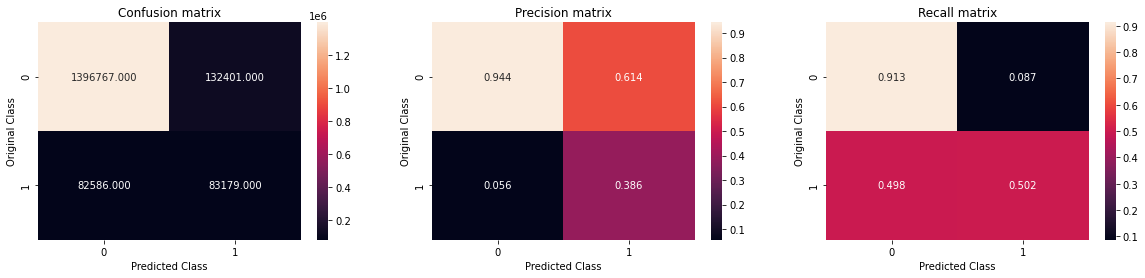

In [16]:
# Confusion, Precision and Recall matrix
plot_confusion_matrix(y_test,y_pred_test)